Ноутбук сделан для генерации наборов данных для решения задачи "на производную" в некоем контесте по Python на ФАЛТ. 

Источник вдохновения: [Третий модуль](https://github.com/engineersCode/EngComp3_tourdynamics) курса [Engineering Computations](https://github.com/engineersCode/EngComp) профессора Лорены Барба.

Собственно, изначально задача состоит в следующем. Дан текстовый файл с координатами падающего теннисного мяча. В файле две колонки: первая — время, вторая — $y$ координата мяча. Нужно его зачитать и численно продифференцировать по времени два раза.

"Экспериментальные" данные можно скачать с сайта курса:

```Python
filename = 'fallingtennisball02.txt'
url = 'http://go.gwu.edu/engcomp3data1'
urlretrieve(url, filename)
```

Этот же файл лежит в директории `exp_data` настоящего репозитория

In [32]:
import numpy
from matplotlib import pyplot
import os.path

In [4]:
filename = './exp_data/fallingtennisball02.txt'
t, y = numpy.loadtxt(filename, usecols=[0,1], unpack=True)

Посмотрим, что в нём:

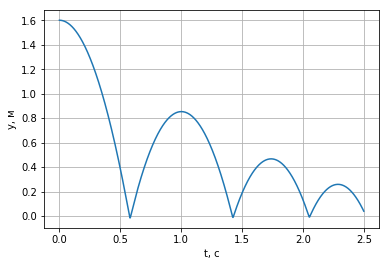

In [5]:
fig = pyplot.figure(figsize=(6,4))
pyplot.xlabel('t, c')
pyplot.ylabel('y, м')
pyplot.grid()
pyplot.plot(t,y);

Определяем мщмент первого отскока

In [6]:
ground = numpy.where(y<0.0001)[0][0]

Вычисляем шаг по времени

In [7]:
dt = t[1]-t[0]
dt

0.001000000000000002

 Считаем скорость и ускорение

In [8]:
vy = (y[1:ground] - y[:ground-1]) / dt
ay = (vy[1:] - vy[:-1]) / dt

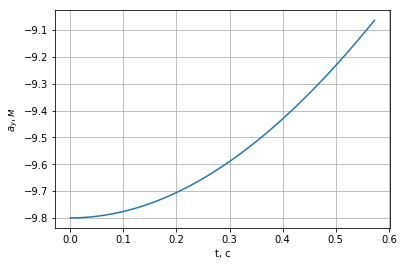

In [9]:
fig = pyplot.figure(figsize=(6,4))
pyplot.xlabel('t, c')
pyplot.ylabel(r'$a_y, м$')
pyplot.grid()
pyplot.plot(t[:ground-2],ay);

In [10]:
print('Ускорение в вертикальном направлении: {:.2f}'.format(ay.mean()))

Ускорение в вертикальном направлении: -9.55


Ускорение получилось переменным, потому что на шарик действует сила сопротивления воздуха!

\begin{equation}
    F_d = \frac{1}{2} C_d \rho v^2  S_{mid},
\end{equation}

где $\rho$ — плотность воздуха, $S_{mid}$ характерная площадь тела. Для шарика $S_{mid} = \pi R^2$

Для вектора вертикальных координаты и скорости

\begin{equation}
\mathbf{y} = \begin{bmatrix}
y \\ v
\end{bmatrix}.
\end{equation}

с учетом сопротивления можно записать уравнения движения следующее:

\begin{equation}
\dot{\mathbf{y}} = \begin{bmatrix}
v \\ a_y
\end{bmatrix},
\end{equation}

где $a_y$ включает в себя ускорение свободного падения и сопротивление:

\begin{eqnarray}
 a_y = -g + a_{\text{drag}} \\
 a_{\text{drag}} = \frac{1}{2m} \pi R^2 \rho C_d v^2
\end{eqnarray}

Итого, имеем:


\begin{equation}
\dot{\mathbf{y}} = \begin{bmatrix}
v \\ -g + a_{\text{drag}}
\end{bmatrix}.
\end{equation}

Соответствующая функция для правой части уравнения движения:

In [52]:
def fall_drag(state,C_d):
    '''Computes the right-hand side of the differential equation
    for the fall of a ball, with drag, in SI units.
    
    Arguments
    ----------    
    state : array of two dependent variables [y v]^T
    
    Returns
    -------
    derivs: array of two derivatives [v (-g+a_drag)]^T
    '''
    R = 0.0661/2 # radius in meters
    m = 0.0577   # mass in kilograms
    rho = 1.22   # air density kg/m^3
    #C_d = 0.47   # drag coefficient for a sphere
    pi = numpy.pi
    
    a_drag = 1/(2*m) * pi * R**2 * rho * C_d * (state[1])**2
    
    
    derivs = numpy.array([state[1], -9.80665 - numpy.sign(state[1]) * a_drag])
    if state[0] <= 0:
        state[1] = abs(state[1])
    return derivs

Теперь, если проинтегрировать, нарпимер методом Рунге-Кутты 4го порядка, получившуюся систему уравнений, для _различных коэффициентов сопротивления_ можно получить _различные_ необходимые наборы данных. Для начала проверим, что получилось на сфере 

In [23]:
def rk4(state, rhs, dt, C_d):
    '''Uses 4th order Runge-Kutta method to update a state to the next one. 
    
    Arguments
    ---------
    state: array of two dependent variables [y v]^T
    rhs  : function that computes the right hand side of the 
           differential equation.
    dt   : float, time increment. 
    
    Returns
    -------
    next_state: array, updated state after one time increment.       
    '''
    k0 = dt * rhs(state,C_d)
    k1 = dt * rhs(state + 0.5 * k0,C_d)
    k2 = dt * rhs(state + 0.5 * k1,C_d)
    k3 = dt * rhs(state + k2,C_d)
    next_state = state + (1/6)*(k0 + 2*k1 + 2*k2 + k3)
    return next_state

In [20]:
dt = 0.001 #шаг по времени
y0 = y[0]  #начальное положение
v0 = 0     #начальная скорость

In [21]:
current_state = numpy.array([y0, v0])
system = numpy.copy(current_state)
height=y0
while height> 0:
    
    new_state = rk4(current_state, fall_drag, dt,0.47)
    system = numpy.vstack((system,new_state))
    current_state = numpy.copy(new_state)
    height = new_state[0]

На графике ниже — разница посчитанных и экспериментальных данных

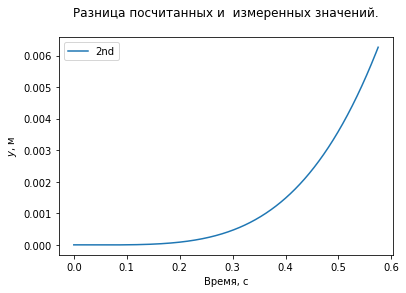

In [22]:
fig = pyplot.figure(figsize=(6,4))

pyplot.plot(t[:ground], y[:ground]-system[:,0],label='2nd')

pyplot.legend(loc='best')
pyplot.title('Разница посчитанных и  измеренных значений.\n')
pyplot.xlabel('Время, с')
pyplot.ylabel('$y$, м');

Точность получилась приемлемая. Теперь возьмем различные коэффициенты сопротивления [отсюда](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%81%D0%BE%D0%BF%D1%80%D0%BE%D1%82%D0%B8%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F_%D1%84%D0%BE%D1%80%D0%BC%D1%8B)

|Тело     | $C_D$|
|---------|------|
|Сфера	  | 0,47 |
|Конус 2:1| 0,50 |
|Куб 	  | 1,05 |
|Цилиндр  |	0,82 |
|Капля    |	0,04 |


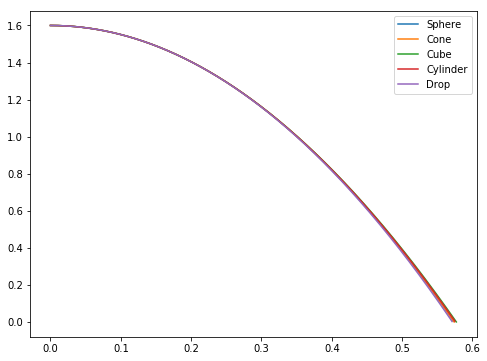

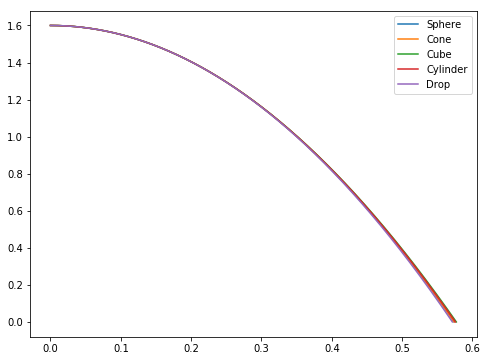

In [58]:
for dt in (0.001,0.0001): #шаг по времени
    pyplot.figure(figsize=(8,6))
    for key,value in {'Sphere' : 0.47,
                      'Cone'   : 0.5,
                     'Cube'    : 1.05,
                     'Cylinder': 0.82,
                     'Drop'    : 0.04}.items():
    
    

        current_state = numpy.array([y0, v0])
        system = numpy.copy(current_state)
        height=y0
        while True:

            new_state = rk4(current_state, fall_drag, dt,value)
            if new_state[0] <= 0:
                break

            system = numpy.vstack((system,new_state))
            current_state = numpy.copy(new_state)
            height = new_state[0]
        to_save = numpy.vstack((dt*numpy.arange(system.shape[0]),system[:,0]))
        numpy.savetxt(os.path.join('data','{}_t_y_dt_{}.dat'.format(key,dt)),to_save.T)
        pyplot.plot(dt*numpy.arange(system.shape[0]),system[:,0],label = key)

    pyplot.legend(loc='best')